## Code corresponding to the Monte Carlo Tree Search Algorithms

In [1]:
import chess
import copy
import math
import numpy as np
import random
import sys
import typing

from time import time
from typing import ClassVar, Callable, Counter, Dict, Generic, Hashable, Iterable, Iterator, List, Mapping, Optional, SupportsInt, Tuple, Type, TypeVar, Union
from chess import Board

In [2]:
STARTING_FEN = "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1"
BaseBoardT = TypeVar("BaseBoardT", bound="BaseBoard")
MAXLEGALMOVES = 200
MAXCODELEGALMOVES = 1000

We will use the class `Board` from the package `chess` and modify it to create a custom model of the chess board

In [30]:
class NewBoard(Board):
    def __init__(self, fen: Optional[str] = STARTING_FEN, *, chess960: bool = False):
        Board.__init__(self, fen)
        self.h = self.board_fen()

    def playout(self, depth=0):
        """Set depth=0 to infinite-length exploration"""
        count = 0
        while(True and ((not depth) or count < depth)):
            moves = self.legalMoves()
            if self.outcome():
                return self.score()
            else:
                n = random.randint(0, len (moves) - 1)
                self.play(moves[n])
            count += 1
        return self.score()
            
    def play(self, move):
        self.push_san(str(move))
    
    def legalMoves(self):
        return [str(a) for a in list(self.legal_moves)]
    
    def score(self):
        _outcome = self.outcome()
        if _outcome is None:
            return 0.5
        result = _outcome.result()
        if result=='1-0': return 1.
        elif result=='0-1': return 0.
        return 0.5
    
    def terminal(self):
        if self.score() == 0.5 and not self.outcome():
            return False
        return True

In [4]:
def look(board):
    return Table.get(board.h, None)

In [5]:
#MaxCodeLegalMoves = 2 * Dx * Dy * 3
MaxCodeLegalMoves = 100
MaxLegalMoves = 100

In [6]:
def add(board):
    nplayouts = [0.0 for _ in range(MaxLegalMoves)]
    nwins = [0.0 for _ in range(MaxLegalMoves)]
    Table[board.h] = [1, nplayouts, nwins]

Now we create a function to setup the board in different positions

In [7]:
def create_board(situation='initial'):
    board = NewBoard()
    if situation == 'initial': return board
    board.push_san('g1f3')
    board.push_san('b8a6')
    board.push_san('f3g1')
    board.push_san('a6b8')
    board.push_san('e2e4')
    board.push_san('b8a6')
    board.push_san('d1f3')
    board.push_san('a6b8')
    board.push_san('f1c4')
    if situation == 'one_move':
        board.push_san('d7d6')
        board.push_san('f3f7')
    elif situation == 'mate_in_one':
        board.push_san('b8a6')
    return board

For example, by giving the argument 'mate_in_one', this function will create a board with a mate-in-one position 

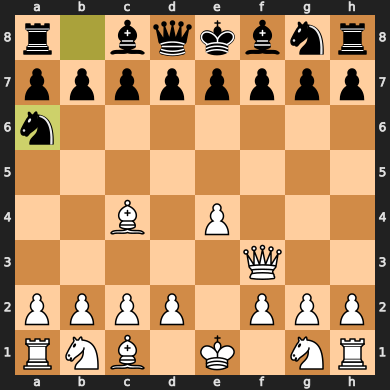

In [33]:
board = create_board('mate_in_one')
board

In [9]:
list(board.legal_moves)

[Move.from_uci('c4f7'),
 Move.from_uci('c4e6'),
 Move.from_uci('c4a6'),
 Move.from_uci('c4d5'),
 Move.from_uci('c4b5'),
 Move.from_uci('c4d3'),
 Move.from_uci('c4b3'),
 Move.from_uci('c4e2'),
 Move.from_uci('c4f1'),
 Move.from_uci('f3f7'),
 Move.from_uci('f3f6'),
 Move.from_uci('f3h5'),
 Move.from_uci('f3f5'),
 Move.from_uci('f3g4'),
 Move.from_uci('f3f4'),
 Move.from_uci('f3h3'),
 Move.from_uci('f3g3'),
 Move.from_uci('f3e3'),
 Move.from_uci('f3d3'),
 Move.from_uci('f3c3'),
 Move.from_uci('f3b3'),
 Move.from_uci('f3a3'),
 Move.from_uci('f3e2'),
 Move.from_uci('f3d1'),
 Move.from_uci('g1h3'),
 Move.from_uci('g1e2'),
 Move.from_uci('e1e2'),
 Move.from_uci('e1f1'),
 Move.from_uci('e1d1'),
 Move.from_uci('b1c3'),
 Move.from_uci('b1a3'),
 Move.from_uci('e4e5'),
 Move.from_uci('h2h3'),
 Move.from_uci('g2g3'),
 Move.from_uci('d2d3'),
 Move.from_uci('c2c3'),
 Move.from_uci('b2b3'),
 Move.from_uci('a2a3'),
 Move.from_uci('h2h4'),
 Move.from_uci('g2g4'),
 Move.from_uci('d2d4'),
 Move.from_uci('

## UCB Player

In [10]:
def UCB(board, n=10):
    #print('lets go')
    moves = [str(a) for a in reversed(board.legalMoves())]
    #print(f'moves: {moves}')
    sumScores = [0.0 for x in range (len(moves))]
    nbVisits = [0 for x in range (len(moves))]
    for i in range(n):
        print('.', end='')
        bestScore = 0
        bestMove = moves[0]
        for m in range (len(moves)):
            score = -10000
            if nbVisits [m] > 0:
                 score = sumScores [m] / nbVisits [m] + 0.4 * math.sqrt (math.log (i) / nbVisits [m])
            if score > bestScore:
                bestScore = score
                bestMove = moves[m]
        b = copy.deepcopy(board)
        b.play(bestMove)
        #print(b)
        r = b.playout(depth=2000)
        #print(board.turn)
        if board.turn == False:
            r = 1.0 - r
        sumScores [m] += r
        nbVisits [m] += 1
    #print(nbVisits)
    #print(sumScores)
    bestScore = 0
    bestMove = moves[0]
    #print(moves)
    print(nbVisits)
    for m in range(len(moves)):
        score = nbVisits[m]
        if score > bestScore:
            bestScore = score
            bestMove = moves[m]
    return bestMove, b

In [11]:
def UCT(board):
    if (board.terminal()):
        return board.score()
    t = look(board)
    if t != None:
        bestValue = -1000000.0
        best = 0
        moves = board.legalMoves()
        for i in range(0, len(moves)):
            val = 1000000.0
            #print(t)
            if t[1][i] > 0:
                Q = t[2][i] / t[1][i]
                if board.turn == False:
                    Q = 1 - Q
                val = Q + 0.4 * math.sqrt(math.log(t[0]) / t[1][i])
            if val > bestValue:
                bestValue = val
                best = i
        board.play(moves[best])
        res = UCT(board)
        t[0] += 1
        t[1][best] += 1
        t[2][best] += res
        return res
    else:
        add(board)
        return board.playout()

In [36]:
def BestMoveUCT(board, n, verbose=False):
    Table = {}
    #if verbose: t0=time()
    for i in range(n):
        #print('.', end='')
        b1 = copy.deepcopy(board)
        res = UCT(b1)
        if verbose and i%(n/10)==0:
            print('.', end='')
    t = look(board)
    moves = board.legalMoves()
    best = moves[0]
    bestValue = t[1][0]
    for i in range(1, len(moves)):
        if (t[1][i] > bestValue):
            bestValue = t[1][i]
            best = moves[i]
    return best

In [13]:
def random_move(board):
    all_moves = list(board.legalMoves())
    r_move = random.choice(all_moves)
    return r_move

In [25]:
board = create_board('mate_in_one')

In [42]:
board = NewBoard(fen="8/8/3b1P1k/7p/3BB2P/1r4PK/8/5R2 w - - 1 58")

In [44]:
look(board)

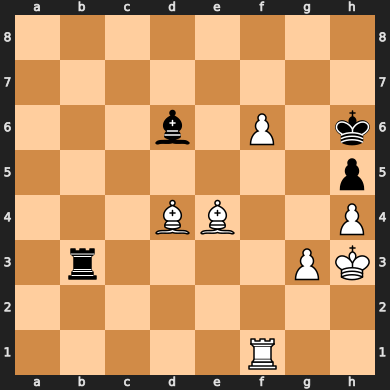

In [45]:
board

In [46]:
#%%time
Table = {}
BestMoveUCT(board, 100, verbose=True)

..........

TypeError: 'NoneType' object is not subscriptable

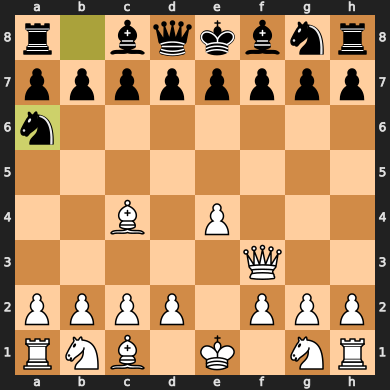

In [27]:
board

#### Let's make a game

In [86]:
board = NewBoard()
Table = {}
i = 1
t0 = time()
while not board.terminal():
    print(f'Move {i}\tElapsed time: {(time() - t0) / 60:.3f} mins')
    white_move = BestMoveUCT(board, 100)
    board.play(white_move)
    if board.turn:
        print('white')
        break
    black_move = random_move(board)
    board.play(black_move)
    i += 1

Move 1	Elapsed time: 0.000 mins
Move 2	Elapsed time: 0.081 mins
Move 3	Elapsed time: 0.203 mins
Move 4	Elapsed time: 0.340 mins
Move 5	Elapsed time: 0.449 mins
Move 6	Elapsed time: 0.580 mins
Move 7	Elapsed time: 0.718 mins
Move 8	Elapsed time: 0.841 mins
Move 9	Elapsed time: 0.958 mins
Move 10	Elapsed time: 1.087 mins
Move 11	Elapsed time: 1.222 mins
Move 12	Elapsed time: 1.359 mins
Move 13	Elapsed time: 1.491 mins
Move 14	Elapsed time: 1.622 mins
Move 15	Elapsed time: 1.757 mins
Move 16	Elapsed time: 1.875 mins
Move 17	Elapsed time: 1.996 mins
Move 18	Elapsed time: 2.107 mins
Move 19	Elapsed time: 2.218 mins
Move 20	Elapsed time: 2.328 mins
Move 21	Elapsed time: 2.454 mins
Move 22	Elapsed time: 2.580 mins
Move 23	Elapsed time: 2.713 mins
Move 24	Elapsed time: 2.863 mins
Move 25	Elapsed time: 2.994 mins
Move 26	Elapsed time: 3.115 mins
Move 27	Elapsed time: 3.244 mins
Move 28	Elapsed time: 3.390 mins
Move 29	Elapsed time: 3.502 mins
Move 30	Elapsed time: 3.622 mins
Move 31	Elapsed tim

In [81]:
def addAMAF(board, table):
    nplayouts = [0.0 for x in range (MAXLEGALMOVES)]
    nwins = [0.0 for x in range (MAXLEGALMOVES)]
    nplayoutsAMAF = [0.0 for x in range (MAXCODELEGALMOVES)]
    nwinsAMAF = [0.0 for x in range (MAXCODELEGALMOVES)]
    table[board.h] = [0, nplayouts, nwins, nplayoutsAMAF, nwinsAMAF]
    return table

In [89]:
def playoutAMAF(board, played):
    while True:
        moves = []
        moves = [str(a) for a in list(board.legal_moves)]
        if len(moves) == 0 or board.terminal():
            return board.score()
        n = random.randint(0, len(moves) - 1)
        played.append(moves[n])
        board.play(moves[n])

In [83]:
def RAVE(board, table, played):
    if board.terminal():
        return board.score()
    t = look(board)
    if t != None:
        bestValue = -1000000.0
        best = 0
        moves = [str(a) for a in list(board.legal_moves)]
        bestcode = moves [0].code(board)
        for i in range(0, len(moves)):
            val = 1000000.0
            code = moves[i].code(board)
            if t[3][code] > 0:
                beta = t[3][code] /(t[1][i] + t[3][code] + 1e-5 * t[1][i] * t[3][code])
                Q = 1
                if t[1][i] > 0:
                    Q = t[2][i] / t[1][i]
                    if board.turn is False:
                        Q = 1 - Q
                AMAF = t[4][code] / t[3][code]
                if board.turn is False:
                    AMAF = 1 - AMAF
                val = (1.0 - beta) * Q + beta * AMAF
            if val > bestValue:
                bestValue = val
                best = i
                bestcode = code
        board.play(moves [best])
        res = RAVE(board, table, played)
        t[0] += 1
        t[1][best] += 1
        t[2][best] += res
        played.insert(0, bestcode)
        for k in range(len(played)):
            code = played [k]
            seen = False
            for j in range(k):
                if played [j] == code:
                    seen = True
            if not seen:
                t[3][code] += 1
                t[4][code] += res
        return res
    else:
        table = addAMAF(board, table)
        return playoutAMAF(board, played)

In [84]:
def BestMoveRAVE(board, table, n):
    for i in range(n):
        #print(f'aqui: {i}')
        b1 = copy.deepcopy(board)
        res = RAVE(b1, table, [])
    t = look(board)
    moves = [str(a) for a in list(board.legal_moves)]
    best = moves[0]
    bestValue = t[1][0]
    for i in range(1, len(moves)):
        if t[1][i] > bestValue:
            bestValue = t[1][i]
            best = moves[i]
    return best

In [85]:
board = create_board('mate_in_one')

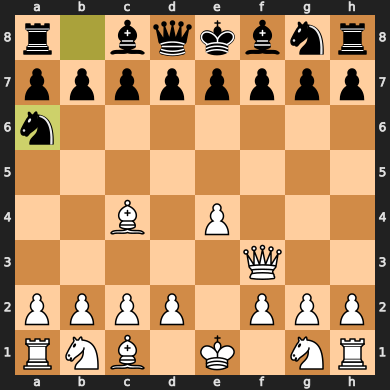

In [86]:
board

In [630]:
print(sys.getrecursionlimit())
sys.setrecursionlimit(30000)
print(sys.getrecursionlimit())

10000
30000


#### Code for further experiments

In [526]:
def GRAVE(board, played, tref):
    moves = board.legalMoves ()
    if (board.terminal ()):
        return board.score()
    t = look(board)
    if t != None:
        tr = tref
        if t[0] > 50:
            tr = t
        bestValue = -1000000.0
        best = 0
        #bestcode = moves[0]
        for i in range (0, len (moves)):
            m = moves[i]
            #val = 1000000.0
            #code = moves [i].code ()
            w = t[2][i]
            p = t[1][i]
            print(tr)
            wa = tr[4][i]
            pa = tr[3][i]
            if pa > 0:
                beta = pa / (pa + p + 1e-5 * pa * p)
                _AMAF = wa / pa
                if p > 0:
                    Q = w / p
                    if board.turn == False:
                        Q = 1 - Q
                if board.turn == False:
                    _AMAF = 1 - _AMAF
                val = (1. - beta) * Q + beta * _AMAF
            #if tr [3] [code] > 0:
            #    beta = tr [3] [code] / (t [1] [i] + tr [3] [code] + 1e-5 * t [1] [i] * tr [3] [code])
            #    Q = 1
            #    if t [1] [i] > 0:
            #        Q = t [2] [i] / t [1] [i]
            #        if board.turn == Black:
            #            Q = 1 - Q
            #    AMAF = tr [4] [code] / tr [3] [code]
            #    if board.turn == Black:
            #        AMAF = 1 - AMAF
            #    val = (1.0 - beta) * Q + beta * AMAF
            if val > bestValue:
                bestValue = val
                best = i
                #bestcode = code
                bestcode = m
        board.play(m)
        played.append(m)
        res = GRAVE(board, played, tr)
        t [0] += 1
        t [1] [best] += 1
        t [2] [best] += res
        for i in range (len (played)):
            code = played [i]
            seen = False
            for j in range (i):
                if played [j] == code:
                    seen = True
            if not seen:
                t [3] [code] += 1
                t [4] [code] += res
        return res
    else:
        addAMAF(board)
        return playoutAMAF(board, played)

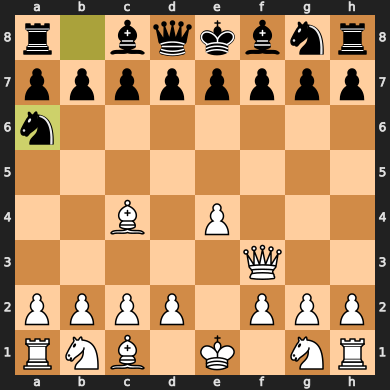

In [527]:
board

In [2]:
def SequentialHalving (state, budget):
    moves = legalMoves (state)
    nplayouts = [0.0 for x in range (MaxCodeLegalMoves)]
    nwins = [0.0 for x in range (MaxCodeLegalMoves)]
    while (len (moves) > 1):
        for m in moves:
            for i in range (budget // (len (moves) * np.log2 (total))):
                s = copy.deepcopy (state)
                play (s, m)
                res = UCT (s)
                nplayouts [m.code (state)] += 1
                if state.turn == White:
                    nwins [m.code (state)] += res
                else:
                    nwins [m.code (state)] += 1.0 - res
        moves = bestHalf (moves, nwins, nplayouts)
    return moves [0]

In [5]:
def bestHalf(state, moves, nwins, nplayouts):
    half = []
    notused = [True for x in range(MaxCodeLegalMoves)]
    for i in range(len(moves) // 2):
        best = -1.0
        bestMove = moves [0]
        for m in moves:
            code = m.code(state)
            if notused[code]:
                mu = nwins[code] / nplayouts[code]
                if mu > best:
                    best = mu
                    bestMove = m
        notused [bestMove.code (state)] = False
        half.append(bestMove)
    return half

In [6]:
def updateAMAF(t, played):
    for i in range (len (played)):
        code = played [i]
        seen = False
        for j in range (i):
            if played [j] == code:
                seen = True
        if not seen:
            t [3] [code] += 1
            t [4] [code] += res

In [9]:
def SHUSS(state, budget):
    Table = {}
    addAMAF(board)
    t = look(board)
    moves = legalMoves(state)
    nplayouts = [0.0 for x in range(MaxCodeLegalMoves)]
    nwins = [0.0 for x in range(MaxCodeLegalMoves)]
    while (len (moves) > 1):
        for m in moves:
            for i in range(budget // (len(moves) * np.log2(total))):
                s = copy.deepcopy(state)
                play(s, m)
                played = [m.code(state)]
                res = GRAVE(s, played, t)
                updateAMAF(t, played)
                nplayouts[m.code (state)] += 1
                if state.turn == White:
                    nwins[m.code (state)] += res
                else:
                    nwins[m.code (state)] += 1.0 - res
        moves = bestHalf(t, state, moves, nwins, nplayouts)
    return moves[0]

In [10]:
def bestHalfSHUSS (t, state, moves, nwins, nplayouts):
    half = []
    notused = [True for x in range (MaxCodeLegalMoves)]
    c = 128
    for i in range (len (moves) // 2):
        best = -1.0
        bestMove = moves [0]
        for m in moves:
            code = m.code (state)
            if notused [code]:
                AMAF = t [4] [code] / t [3] [code]
                if state.turn == Black:
                    AMAF = 1 - AMAF
                mu = nwins [code] / nplayouts [code] + c * AMAF / nplayouts [code]
                if mu > best:
                    best = mu
                    bestMove = m
        notused [bestMove.code (state)] = False
        half.append (bestMove)
    return half

In [11]:
def PUCT (board):
    if board.terminal ():
        return board.score ()
    t = look (board)
    if t != None:
        bestValue = -1000000.0
        best = 0
        moves = board.legalMoves ()
        for i in range (0, len (moves)):
            # t [4] = value from the neural network
            Q = t [4]
            if t [1] [i] > 0:
                Q = t [2] [i] / t [1] [i]
            if board.turn == Black:
                Q = 1 - Q
            # t [3] = policy from the neural network
            val = Q + 0.4 * t [3] [i] * sqrt (t [0]) / (1 + t [1] [i])
            if val > bestValue:
                bestValue = val
                best = i
        board.play (moves [best])
        res = PUCT (board)
        t [0] += 1
        t [1] [best] += 1
        t [2] [best] += res
        return res
    else:
        t = add (board)
        return t [4]